## Twitter US Airline Sentiment

[kaggle dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

To build a machine learning model that can predict if a customer's tweet regarding the airline is positive or negative.

#### context
This project is less focused on NLP techniques and more focused on the sentiment analysis while trying to keep it simple, the model will likely scale to airlines data and will be effective for it.<br>
Currently this project uses basic tokenization only. No other NLP techniques like stopwords or lemmetization has been used.<br>

<hr>Some of the ideas (like embedding) are taken from kaggle notebooks from 

[here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

but because there are so many and I can't find the exact notebook I can't credit the specific individual (sorry!).

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

The goal is to make a binary classifier that labels a tweet positive or negative, we won't need the neutral opinions.

In [37]:
df = df[['text','airline_sentiment']]
df = df[df['airline_sentiment'] != 'neutral']
df.reset_index(inplace=True)
#tweet_df.head(5)
df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

## Preprocessing

In [38]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.append('rt')
stop.append('https')
stop.append('http')
stop.append('@')
stop.append('#')
stop.append(' ')
stop.append('...')

words = []
for i in range(len(df)):
    tweet = df['text'][i]
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [word for word in tweet if word not in stop]
    tweet = ' '.join(tweet)
    words.append(tweet)


In [39]:
sent_col = df.airline_sentiment.factorize()
sent_col

(array([0, 1, 1, ..., 0, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

The fit_on_texts() method creates an association between the words and the assigned numbers. This association is stored in the form of a dictionary in the tokenizer.word_index attribute.

In [41]:
tweet = df.text.values
tokenizer = Tokenizer(num_words=5000)
#assign nos. to words
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
#replace the words with the numbers
encoded_docs = tokenizer.texts_to_sequences(tweet)
#Use padding to pad the sentences to have equal length
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [42]:
#print(tokenizer.word_index)

### Model

Trying two popular text classification models:
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

model1 = MultinomialNB()
model2 = LogisticRegression(solver='lbfgs', max_iter=2000)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequence, sent_col[0], test_size=0.2, random_state=42)

In [45]:
model1.fit(x_train, y_train)
model2.fit(x_train, y_train)
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)

In [46]:
print("MultinomialNB:", accuracy_score(y_test, pred1))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred1))
print("LogisticRegression:", accuracy_score(y_test, pred2))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred2))

MultinomialNB: 0.5365959289735817
Confusion Matrix:
 [[347 100]
 [970 892]]
LogisticRegression: 0.8064097011693374
Confusion Matrix:
 [[   0  447]
 [   0 1862]]


Looking at above data we can certainly say that we need something better than a simple logistic regression.

#### LSTM
- [LSTM](https://keras.io/layers/recurrent/)

We use LSTM layers as the machine learning model. The architecture of the model is embedding layer, an LSTM layer, and a Dense layer at the end. To avoid overfitting, we introduced the Dropout mechanism in-between the LSTM layers.
Could have used RNN but LSTM has the memory advantage

In [47]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, SpatialDropout1D

In [48]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.3))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.4))
model.add(Dropout(0.2))
#model.add(Dense(2, activation='sigmoid')) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
________________________________________________

In [49]:
history = model.fit(padded_sequence,sent_col[0],validation_split=0.25, epochs=5, batch_size=32)

Epoch 1/5
271/271 [==============================] - 42s 143ms/step - loss: 0.4094 - accuracy: 0.8277 - val_loss: 0.2155 - val_accuracy: 0.9168
Epoch 2/5
271/271 [==============================] - 39s 143ms/step - loss: 0.2267 - accuracy: 0.9131 - val_loss: 0.1743 - val_accuracy: 0.9359
Epoch 3/5
271/271 [==============================] - 39s 143ms/step - loss: 0.1708 - accuracy: 0.9366 - val_loss: 0.1795 - val_accuracy: 0.9397
Epoch 4/5
271/271 [==============================] - 39s 142ms/step - loss: 0.1339 - accuracy: 0.9487 - val_loss: 0.1808 - val_accuracy: 0.9439
Epoch 5/5
271/271 [==============================] - 40s 148ms/step - loss: 0.1172 - accuracy: 0.9568 - val_loss: 0.1826 - val_accuracy: 0.9411


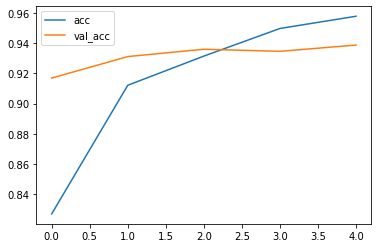

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')

plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

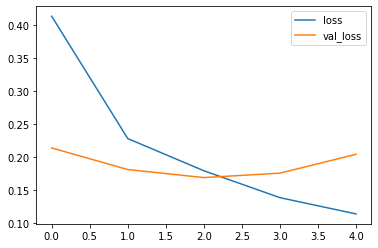

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### A function to easily implement the model

In [20]:
def predict_sent(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: {}".format(prediction))

#### Actual test

In [21]:
test0 = "enjoyed my journey on this flight."
predict_sent(test0)

test1 = "very bad flight experience"
predict_sent(test1)

1/1 [==============================] - 0s 325ms/step
Predicted label: 0
1/1 [==============================] - 0s 29ms/step
Predicted label: 1


#### We have to save this gooood model
I mean 96-94% accuracy without much preprocessing is good.<hr>
Unlike ML Models I cannot just pickle a NN, we save NN into a JSON file while it's weights are saved into .h5 file. Later it can be saved in file, again when loaded it has to be converted into a model using keras model_from_json module.

In [22]:
import os
from keras.models import load_model

if not os.path.exists('../models'):
    os.makedirs('../models')
    
# save model to HDF5
model.save("../models/model.h5")
print("Saved model to disk")

Saved model to disk


## Load and Test

In [23]:
# load and evaluate a saved model
from keras.models import load_model
 
# load model
model = load_model('../models/model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
__________________________________________________

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=300)

In [25]:
def pred_sent(text):
    tokenizer.fit_on_texts([text])
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: {}".format(prediction))

In [26]:
test0 = " thank you for the confortable flight" #spelling mistakes intended
pred_sent(test0)

test1 = "why is the experince with you so bad"
pred_sent(test1)

1/1 [==============================] - 0s 271ms/step
Predicted label: 0
1/1 [==============================] - 0s 34ms/step
Predicted label: 1


#### THEEND